In [1]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [2]:
class Queue:
    def __init__(self, service_distribution):
        self.service_distribution = service_distribution
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_distribution, service_distribution):
        self.queue = Queue(service_distribution)
        self.arrival_distribution = arrival_distribution

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_distribution, service_distribution, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_distribution, service_distribution)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

In [10]:
# Run a short test with an M/M/1 queue

import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

arrival_rate = 0.8
service_rate = 1

arrival_distribution = sts.expon(scale=1/arrival_rate)
service_distribution = sts.expon(scale=1/service_rate)
bus_system = run_simulation(arrival_distribution, service_distribution, run_until=100)
print(f'There are {bus_system.queue.people_in_queue} people in the queue')

There are 2 people in the queue


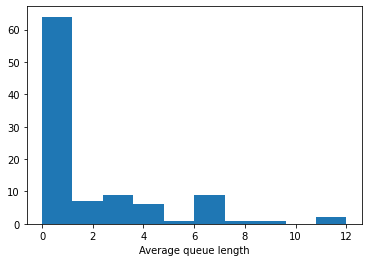

In [12]:
# First experiment: 100 trials

result = []
for i in range(1,101):
    bus_system = run_simulation(arrival_distribution, service_distribution, run_until=i)
    result.append(bus_system.queue.people_in_queue)
results = np.hstack(result)

x = results
plt.figure()
plt.hist(x) # Make a histogram
plt.xlabel('Average queue length')
plt.show()

In [13]:
m = np.mean(x)
t = sts.sem(x)

print('The sample mean is', m)
print('Standard error of the mean:', t)
print('95% confidence interval of population mean:', [m - 1.96*t, m + 1.96*t])

The sample mean is 1.82
Standard error of the mean: 0.2633812768017062
95% confidence interval of population mean: [1.3037726974686559, 2.336227302531344]


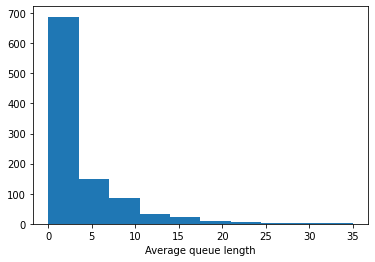

The sample mean is 3.191
Standard error of the mean: 0.14353090301436872
95% confidence interval of population mean: [2.9096794300918374, 3.4723205699081623]


In [15]:
# Second experiment: 1000 trials

result1 = []
for i in range(1,1001):
    bus_system = run_simulation(arrival_distribution, service_distribution, run_until=i)
    result1.append(bus_system.queue.people_in_queue)
results1 = np.hstack(result1)

y = results1
plt.figure()
plt.hist(y) # Make a histogram
plt.xlabel('Average queue length')
plt.show()

m1 = np.mean(y)
t1 = sts.sem(y)

print('The sample mean is', m1)
print('Standard error of the mean:', t1)
print('95% confidence interval of population mean:', [m1 - 1.96*t1, m1 + 1.96*t1])

In [4]:
def run_experiment(arrival_rate_list, service_time_dist, run_until, num_trials):
    '''
    Run an experiment with different arrival rates for an M/G/1 queue. By
    setting the service time distribution appropriately, you can also simulate
    M/D/1 and M/M/1 queues.
    '''
    
    # We record only the mean and standard error of the mean for each experiment
    results_mean = []
    results_std_err = []

    for arrival_rate in tqdm(arrival_rate_list):
        arrival_distribution = sts.expon(scale=1/arrival_rate)
        queue_lengths = []
        for trial in range(num_trials):
            bus_system = run_simulation(
                arrival_distribution, service_time_dist, run_until)
            queue_lengths.append(bus_system.queue.people_in_queue)
        results_mean.append(np.mean(queue_lengths))
        results_std_err.append(sts.sem(queue_lengths))
        
    # Convert lists to arrays so we can easily add, subtract, and multiply them
    results_mean = np.array(results_mean)
    results_std_err = np.array(results_std_err)
    
    return results_mean, results_std_err


def make_error_plot(queue_type, rho, mean, std_err, theoretical_function):
    '''
    Plot the empirical mean and 95% confidence interval of the mean of the queue
    length. Also plot the theoretical value for the average queue length using the
    supplied theoretical function (a function of rho).
    '''
    
    plt.figure(figsize=(8, 6))
    plt.title(f'Average queue length for an {queue_type} queue')
    plt.xlabel('utilization ρ')
    plt.ylabel('average queue length')

    plt.errorbar(
        rho, mean, 1.96 * std_err,
        color='black', marker='o', capsize=5, linestyle='--', linewidth=1,
        label='empirical')

    plt.plot(
        rho, theoretical_function(rho),
        color='red', marker='o', linestyle='--', linewidth=1,
        label='theoretical')

    plt.legend()
    plt.show()

In [5]:
# Run the M/D/1 queue experiment

arrival_rate_list = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95])  # lambda
service_rate = 1  # mu
service_distribution = sts.norm(loc=1/service_rate, scale=0)
run_until = 300
num_trials = 100

md1_mean, md1_std_err = run_experiment(
    arrival_rate_list, service_distribution, run_until, num_trials)
print('M/D/1 experiment complete')

100%|██████████| 6/6 [00:10<00:00,  1.68s/it]

M/D/1 experiment complete


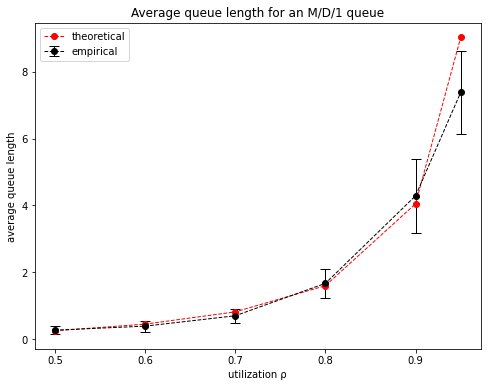

In [6]:
# Plot the M/D/1 results

def theoretical_md1(rho):
    return rho**2 / 2 / (1-rho)

rho = arrival_rate_list / service_rate
make_error_plot('M/D/1', rho, md1_mean, md1_std_err, theoretical_md1)

EmpiricalAnalysis: The results obtained from running a simulation visualize with histograms and error plots, summarized with mean, standard error and confidence interval, and interpreted correctly with comparison between the 100 and 1000 trails. The simulation was running multiple times to derive some insights about how arrival rate relates to average queue length.

Professionalism: I have properly labeled the axes, chosen the appropriate types of graph to present my results. I also produced a well-organized Python notebook and following all presentation guidelines, including detailed in-line code comments for readers. Finally, the pre-class work is completed well before class and uploaded onto the right platform to present in class.